# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [1]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import einops
import sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from src.neuralnetwork.autoencoder.cae_ks_l22 import CAE
from src.neuralnetwork.preprocessing import normalize_data, generate_esn_noise_data, train_valid_test_split
sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

#### 1: Load the trained CAE and the encoded time series

In [2]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)
f = h5py.File('/storage0/eo821/KS/L22/M256_N512_tmax100000_deltat0.05L22.mat','r')
U = np.array(f.get('uu'))[:, 1000::ks_data['upsample']] 
U = einops.rearrange(U, 'x time-> time 1 x')
sysdim = U.shape[0]
print(f"Shape of KS data: {U.shape}")

U_normalized, maxnorm = normalize_data(U, normtype=ks_data['normtype'])
U_train_series, U_valid_series, U_test_series = train_valid_test_split(U_normalized, ks_data)

print(f"CAE details", ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)
print(f"ESN details", esn_loaded_dict)

Shape of KS data: (499751, 1, 512)
CAE details {'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.05, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (399801, 8)
ESN details {'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([ 0.04632736, -0.0202649 , -0.08058597, -0.04703639, -0.14330693,
       -0.03961901, -0.03926516, -0.14617444]), array([0.78222102, 0.80043198, 0.84137316, 0.76709582, 0.69758855,
       0.7997398 , 0.728731  , 0.70858355])], 'input_weights_mode': 'dense', 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4], 'f': array([0.36003981, 0.40722199, 0.42022049, 0.45035164, 0.4855863 ]), 'spectral_radius': array([0.80881943, 0.82161872, 0.79331233, 0.79900527, 0.67501252]), 'input_scaling': array([0.0946024 , 0.09639518, 0.09498936, 0.09443

#### 2: Prepare the encoded data for the ESN training

In [3]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)
# Normalize and split


In [4]:
# Split the data into different datasets
N_washout = esn_loaded_dict["N_washout"]
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+esn_loaded_dict["train_size"]-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+esn_loaded_dict["train_size"], ...]
U_val_input = u_encoded_valid[:esn_loaded_dict["val_size"]-1, ...]
U_val_label = u_encoded_valid[1:esn_loaded_dict["val_size"], ...]
U_test_washout = u_encoded_test[:N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (39601, 8)


#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [5]:
i=0 # choose the best esn 
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                # output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.8711e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [6]:
reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 5000)

#### 5: CAE-ESN prediction on the test data

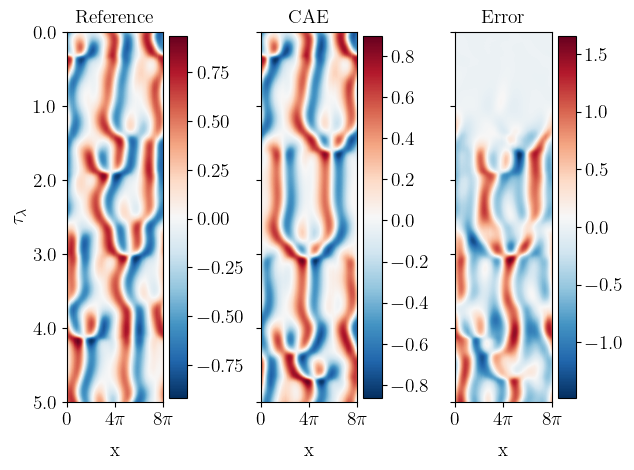

In [7]:
# Define constants
N_lyap = int(1 / ks_data["lyap"] / (ks_data["dt"] * ks_data["upsample"]))
N_plot = 5 * N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length (not used in plot but could be useful)
domain_length = 20 * np.pi

# Create subplots: 1 row, 3 columns, share y-axis
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True) # figsize=(12, 4),

N_start = 200

# Generate ESN prediction
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start : N_start + N_washout, :], 15000)
# Decode predicted and true snapshots - convert tensors to numpy properly
snapshot_decoded = (cae_model.decoder(torch.from_numpy(prediction).float().to(device)).detach().cpu().numpy())
snapshot = (cae_model.decoder(torch.from_numpy(u_encoded_test[N_start + N_washout : N_start + N_washout + 15000, :]).float().to(device)).detach().cpu().numpy())

# Extract data for plotting first channel and N_plot timesteps
data1 = snapshot[:N_plot, 0, :]
data2 = snapshot_decoded[:N_plot, 0, :]
data3 = data1 - data2

# Generate lyapunov time vector
lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, ks_data["dt"] * ks_data["upsample"])

# Adjust subplot spacing to avoid overlap
plt.subplots_adjust(wspace=0.1)

# Plotting loop for Reference, CAE, and Error
for i, data in enumerate([data1, data2, data3]):
    ax = axs[i]

    # extent = [x_min, x_max, y_min, y_max]
    extent = [0, 2 * 4 * np.pi, lyapunov_time[N_plot], lyapunov_time[0]]
    im = ax.imshow(data, aspect="auto", cmap=cmap, extent=extent)

    # X axis labels and ticks
    ax.set_xlabel("x", fontsize=fs, rotation=0, labelpad=10)
    x_ticks_pos = np.arange(0, 8 * np.pi + 0.01, step=4 * np.pi)
    ax.set_xticks(x_ticks_pos)
    ax.set_xticklabels(["0", r"$4\pi$", r"$8\pi$"], fontsize=fs)
    for tick_label in ax.get_xticklabels():
        tick_label.set_ha("center")
        tick_label.set_x(tick_label.get_position()[0])  # reset x pos if needed

    # Y axis ticks and labels, font size
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"{t:.1f}" for t in ax.get_yticks()], fontsize=fs)
    ax.yaxis.tick_left()

    # Add colorbar with adjusted font size
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=fs)

# Y-axis label only on first subplot
axs[0].set_ylabel(r"$\tau_{\lambda}$", fontsize=fs)
# Titles
axs[0].set_title("Reference", fontsize=fs)
axs[1].set_title("CAE", fontsize=fs)
axs[2].set_title("Error", fontsize=fs)

plt.tight_layout()
# Optional: save figure
# plt.savefig("../images/cae-esn.png", dpi=100)
plt.show()

In [8]:
sys.path.append('../')
from src.data_assimilation.enkf import EnKF

In [9]:
import numpy as np

# --- Kalman Filter / EnKF Parameters ---
np.random.seed(123)                # For reproducibility
std_obs = 0.01                    # Observation noise standard deviation
N_ensemble = 50                   # Number of ensemble members
repeats = 20                     # Number of EnKF update repeats
N_steps = N_lyap // 4            # Number of time steps for prediction
washout_size = N_washout         # Washout size for ESN initialization
inputdim = 8                     # Input dimension for ESN observation

# --- Data preparation ---
N_start = 1000
washout_observations = U_test[N_start : N_start + washout_size, :inputdim]
truth = U_test[N_start + washout_size :, :]

# --- Generate noisy ensembles for washout and observations ---
# Noise scaled by std deviation of encoded data for each feature
noise_scale = std_obs * np.std(U_encoded, axis=0)[:inputdim]

washout_noise_ensemble = (washout_observations[np.newaxis, :, :] + np.random.normal(loc=0.0, scale=noise_scale, size=(N_ensemble, washout_size, inputdim)))
observations_ensemble = (truth[:, :inputdim][np.newaxis, :, :] + np.random.normal(loc=0.0, scale=noise_scale, size=(N_ensemble, truth.shape[0], inputdim)))

# --- Measurement downsampling ---
measurements = truth[::N_steps, :inputdim]  # Downsample truth for measurement

# --- Initialize ensemble reservoir states storage ---
reservoir_size = esn_loaded_dict["reservoir_size"]
obs_ensemble = np.zeros((N_ensemble, N_steps, reservoir_size))
obs_ensemble_step = np.zeros((N_ensemble, N_steps, reservoir_size))

# --- Observation noise covariance matrix ---
Cdd = np.diag(std_obs * np.ones(inputdim))  # Covariance matrix (diagonal)

# --- Observation operator matrix (maps reservoir to observations) ---
M = my_ESN.W_out[:, :inputdim].T  # Shape: (inputdim, reservoir_size)

# --- Storage for tracked state over repeats ---
Aa_tracked = np.zeros((repeats, inputdim, N_ensemble))

# --- Generate initial reservoir states by running ESN on washout ensembles ---
for i in range(N_ensemble):
    reservoir, _ = my_ESN.closed_loop_with_washout(washout_noise_ensemble[i], N_steps - 1)
    obs_ensemble[i] = reservoir  # Shape: (N_steps, reservoir_size)

# --- EnKF update loop ---
for j in range(repeats):
    n_t_current = obs_ensemble.shape[1] - 1  # Last time step index
    
    # EnKF update: forecast ensemble Af, observations d, obs cov Cdd, operator M
    Aa = EnKF(
        Af=obs_ensemble[:, -1, :].T,             # Shape: (reservoir_size, N_ensemble)
        d=observations_ensemble[:, n_t_current, :].T,  # Shape: (inputdim, N_ensemble)
        Cdd=Cdd,
        M=M
    )
    
    # Track updated states transformed back to observation space
    Aa_tracked[j] = (Aa.T @ my_ESN.W_out).T  # Shape: (inputdim, N_ensemble)

    # Propagate updated ensembles forward through ESN
    for i in range(N_ensemble):
        reservoir, _ = my_ESN.closed_loop(Aa[:, i], N_steps)
        obs_ensemble_step[i] = reservoir[1:]  # Skip first state? Adjust if needed

    # Append new states to obs_ensemble along time axis
    obs_ensemble = np.concatenate((obs_ensemble, obs_ensemble_step), axis=1)

# Optional: sanity check shapes
assert obs_ensemble.shape[0] == N_ensemble
assert obs_ensemble.shape[2] == reservoir_size



/tmp/ipykernel_3670192/1220574530.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


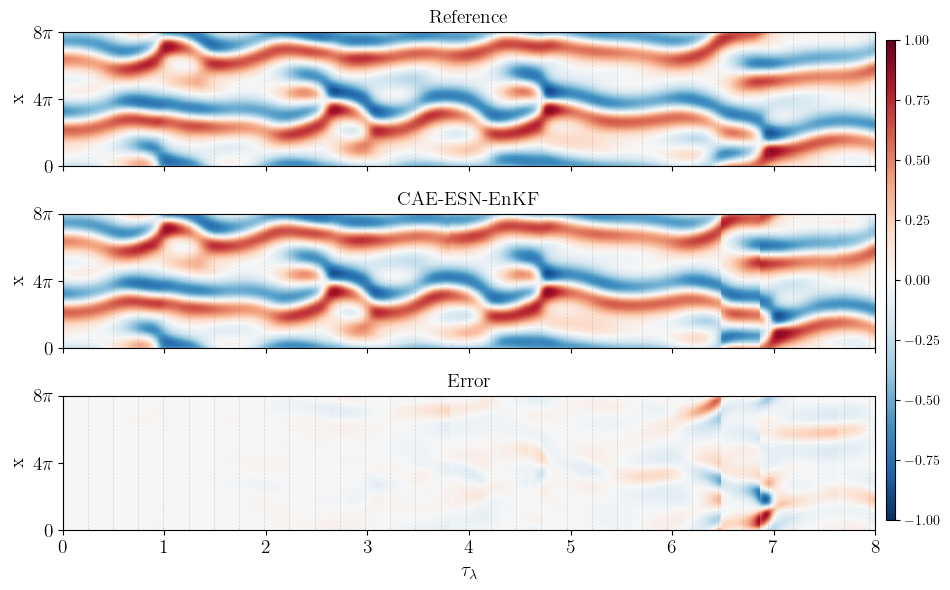

In [ ]:
mean_prediction = np.mean(predictions, axis=0)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+N_plot, :8]).float().to(device)).numpy(force=True)


# Define constants
cmap = 'RdBu_r'
fs = 14
domain_length = 8 * np.pi
N_plot = 1000

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 6), sharex=True)  # Three subplots on top of each other

snapshot_decoded = cae_model.decoder(torch.from_numpy(mean_prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy(truth[:len(time_prediction), :]).float().to(device)).numpy(force=True)

# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

# Calculate min and max values for color scale across all datasets
vmin = -1
vmax = 1
lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"] * ks_data["upsample"]))

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)  # Adjust vertical space between plots

# Plot data with axis switched
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data.T, aspect='auto', cmap=cmap, origin='lower',
                     extent=[int(lyapunov_time[0]), (lyapunov_time[N_plot]), 0, 8 * np.pi],
                     vmin=vmin, vmax=vmax)  # Set color scale limits
    for x in lyapunov_time[:N_plot:N_steps]:
    #     if lyapunov_time[x] < int(lyapunov_time[N_plot]):
        axes.axvline(x=x, color='k', linestyle='--', linewidth=0.5, c="grey", alpha=0.3)


    # Set axis labels
    axes.set_ylabel('x', fontsize=fs)
    axes.set_yticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)))
    axes.set_yticklabels(['0', r'$4\pi$', r'$8\pi$'], fontsize=fs)

    axes.set_xticks(axes.get_xticks())
    axes.set_xticklabels([f'{int(tick)}' for tick in axes.get_xticks()], fontsize=fs)

# Add a single color bar for all plots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.99, 0.125, 0.01, .8])
fig.colorbar(im, cax=cbar_ax)

# Set titles and x-axis for the last plot
axs[0].set_title("Reference", fontsize=fs)
axs[1].set_title("CAE-ESN-EnKF", fontsize=fs)
axs[2].set_title("Error", fontsize=fs)

axs[2].set_xlabel(r'$\tau_{\lambda}$', fontsize=fs)  # Set xlabel on the last subplot
plt.tight_layout()
plt.show()

